In [1]:
# Import common libraries
import numpy as np
import pandas as pd
import os

# Import MNE processing
import mne
from mne.preprocessing.nirs import optical_density, beer_lambert_law

# Import MNE-NIRS processing
from mne_nirs.statistics import run_glm
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import statsmodels_to_results
from mne_nirs.channels import get_short_channels, get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.visualisation import plot_glm_group_topo
from mne_nirs.datasets import fnirs_motor_group
from mne_nirs.visualisation import plot_glm_surface_projection
from mne_nirs.io.fold import fold_channel_specificity

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids, get_entity_vals

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# import raw nirx data
root = "../BIDS_Direct/"
# raw_intensity = mne.io.read_raw_snirf(fname, verbose=True, preload=True)
# raw_intensity.plot_sensors()

dataset = BIDSPath(root=root, task="AnonCom", datatype="nirs", suffix="nirs", extension=".snirf")

ignore = [".DS_Store", "sub-03"]

print(dataset.directory)

../BIDS_Direct/nirs


In [3]:
def individual_analysis(bids_path, ID):
    # print(bids_path, ID)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=True)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Get Events
    events, event_dict = mne.events_from_annotations(raw_intensity, verbose=False)
    
    # Remove all STOP triggers
    events = events[::2]
    
    # Rename Events
    # event_dict = {'Control': 4, 'Neutral': 2, 'Inflammatory': 3, 'Practice': 1}
    
    # Signal Processing
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
    # print("Raw OD", raw_od)
    
    # Convert signal to haemoglobin and resample
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo.resample(0.3)
    # print("Raw Haemo", raw_haemo)
    
    # Make First Level Design Matrix
    design_matrix = make_first_level_design_matrix(raw_haemo, drift_model='cosine', high_pass=0.005, hrf_model='spm', stim_dur=60.0)
    

    # Run GLM
    glm_est = run_glm(raw_haemo, design_matrix)
    
    # Calculate Values of interest
    cha = glm_est.to_dataframe()
    # print('Cha', cha)
    
    # Compute defined contrast
    # print(design_matrix.columns)

    contrast_matrix = np.eye(design_matrix.shape[1])
    basic_conts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
    neutral = basic_conts['Control'] - basic_conts['Neutral']
    inflam = basic_conts['Control'] - basic_conts['Inflammatory']
    
    con_inflam = glm_est.compute_contrast(inflam)
    con_neutral = glm_est.compute_contrast(neutral)
    
    neutral_contrast = con_neutral.to_dataframe()
    inflam_contrast = con_inflam.to_dataframe()
    
    neutral_contrast['Condition'] = 'Neutral'
    inflam_contrast['Condition'] = 'Inflammatory'
    

    return raw_haemo, cha, neutral_contrast, inflam_contrast, glm_est

#  cha = glm_est.to_dataframe()
#  roi = glm_est.to_dataframe_region_of_interest(groups, design_matrix.columns, demographic_info=True)
# contrast = glm_est.compute_contrast(contrast_LvR)
#     con = contrast.to_dataframe()
# raw_haemo

In [4]:
df_con = pd.DataFrame() # used to be df_roi
df_cha = pd.DataFrame()  # To store channel level results
df_con_neutral = pd.DataFrame()  # To store channel level neutral contrast results
df_con_inflam = pd.DataFrame()  # To store channel level inflam contrast results

subjects = os.listdir("../BIDS_Direct/")
for sub in subjects:
    if sub not in ignore:
        # Create path to file based on experiment info
        f_path = f'../BIDS_Direct/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'
        
        # Analyse data and return both ROI and channel results
        raw_haemo, cha, neutral_contrast, inflam_contrast, glm_est = individual_analysis(f_path, sub)
        
        # Append individual results to all participants
        df_cha = pd.concat([df_cha, cha], ignore_index=True)
        df_con_neutral = pd.concat([df_con_neutral, neutral_contrast], ignore_index=True)
        df_con_inflam = pd.concat([df_con_inflam, inflam_contrast], ignore_index=True)


df_con_inflam

# Export Dataframes to CSV files
# df_con_neutral.to_csv('direct_group_neutral.csv')
# df_con_inflam.to_csv('direct_group_inflam.csv')

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-01/nirs/sub-01_task-AnonCom_nirs.snirf
Reading 0 ... 17097  =      0.000 ...  1680.635 secs...
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-02/nirs/sub-02_task-AnonCom_nirs.snirf
Reading 0 ... 14803  =      0.000 ...  1455.135 secs...
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Direct/sub-04/nirs/sub-04_task-AnonCom_nirs.snirf
Reading 0 ... 16842  =      0.000 ...  1655.569 secs...


variable,ContrastType,effect,p_value,stat,z_score,Source,Detector,Chroma,Significant,ch_name,Condition
0,t,-9.696307e-05,0.877388,-1.163442,-1.162026,1,1,hbo,False,S1_D1 hbo,Inflammatory
1,t,-7.342517e-05,0.893179,-1.245254,-1.243612,1,2,hbo,False,S1_D2 hbo,Inflammatory
2,t,-2.487500e-05,0.791537,-0.812462,-0.811764,2,1,hbo,False,S2_D1 hbo,Inflammatory
3,t,-1.044571e-04,0.837142,-0.983780,-0.982779,2,3,hbo,False,S2_D3 hbo,Inflammatory
4,t,-1.986598e-05,0.799190,-0.839471,-0.838731,3,2,hbo,False,S3_D2 hbo,Inflammatory
...,...,...,...,...,...,...,...,...,...,...,...
115,t,1.076691e-05,0.228494,0.744424,0.743816,6,6,hbr,False,S6_D6 hbr,Inflammatory
116,t,-2.721065e-05,0.779164,-0.770017,-0.769373,7,5,hbr,False,S7_D5 hbr,Inflammatory
117,t,-2.127099e-05,0.769549,-0.737959,-0.737361,7,7,hbr,False,S7_D7 hbr,Inflammatory
118,t,3.995274e-06,0.341552,0.408481,0.408231,8,6,hbr,False,S8_D6 hbr,Inflammatory


In [5]:
# Plot the Neutral Results

# grp_results = df_con_neutral.query("Condition in ['Neutral', 'Inflammatory']")
# grp_results = grp_results.query("Chroma in ['hbo','hbr']")

# sns.catplot(x="Condition", y="effect", hue="Significant", col="ch_name", data=grp_results, col_wrap=5, ci=None, palette="muted", height=4, s=10)

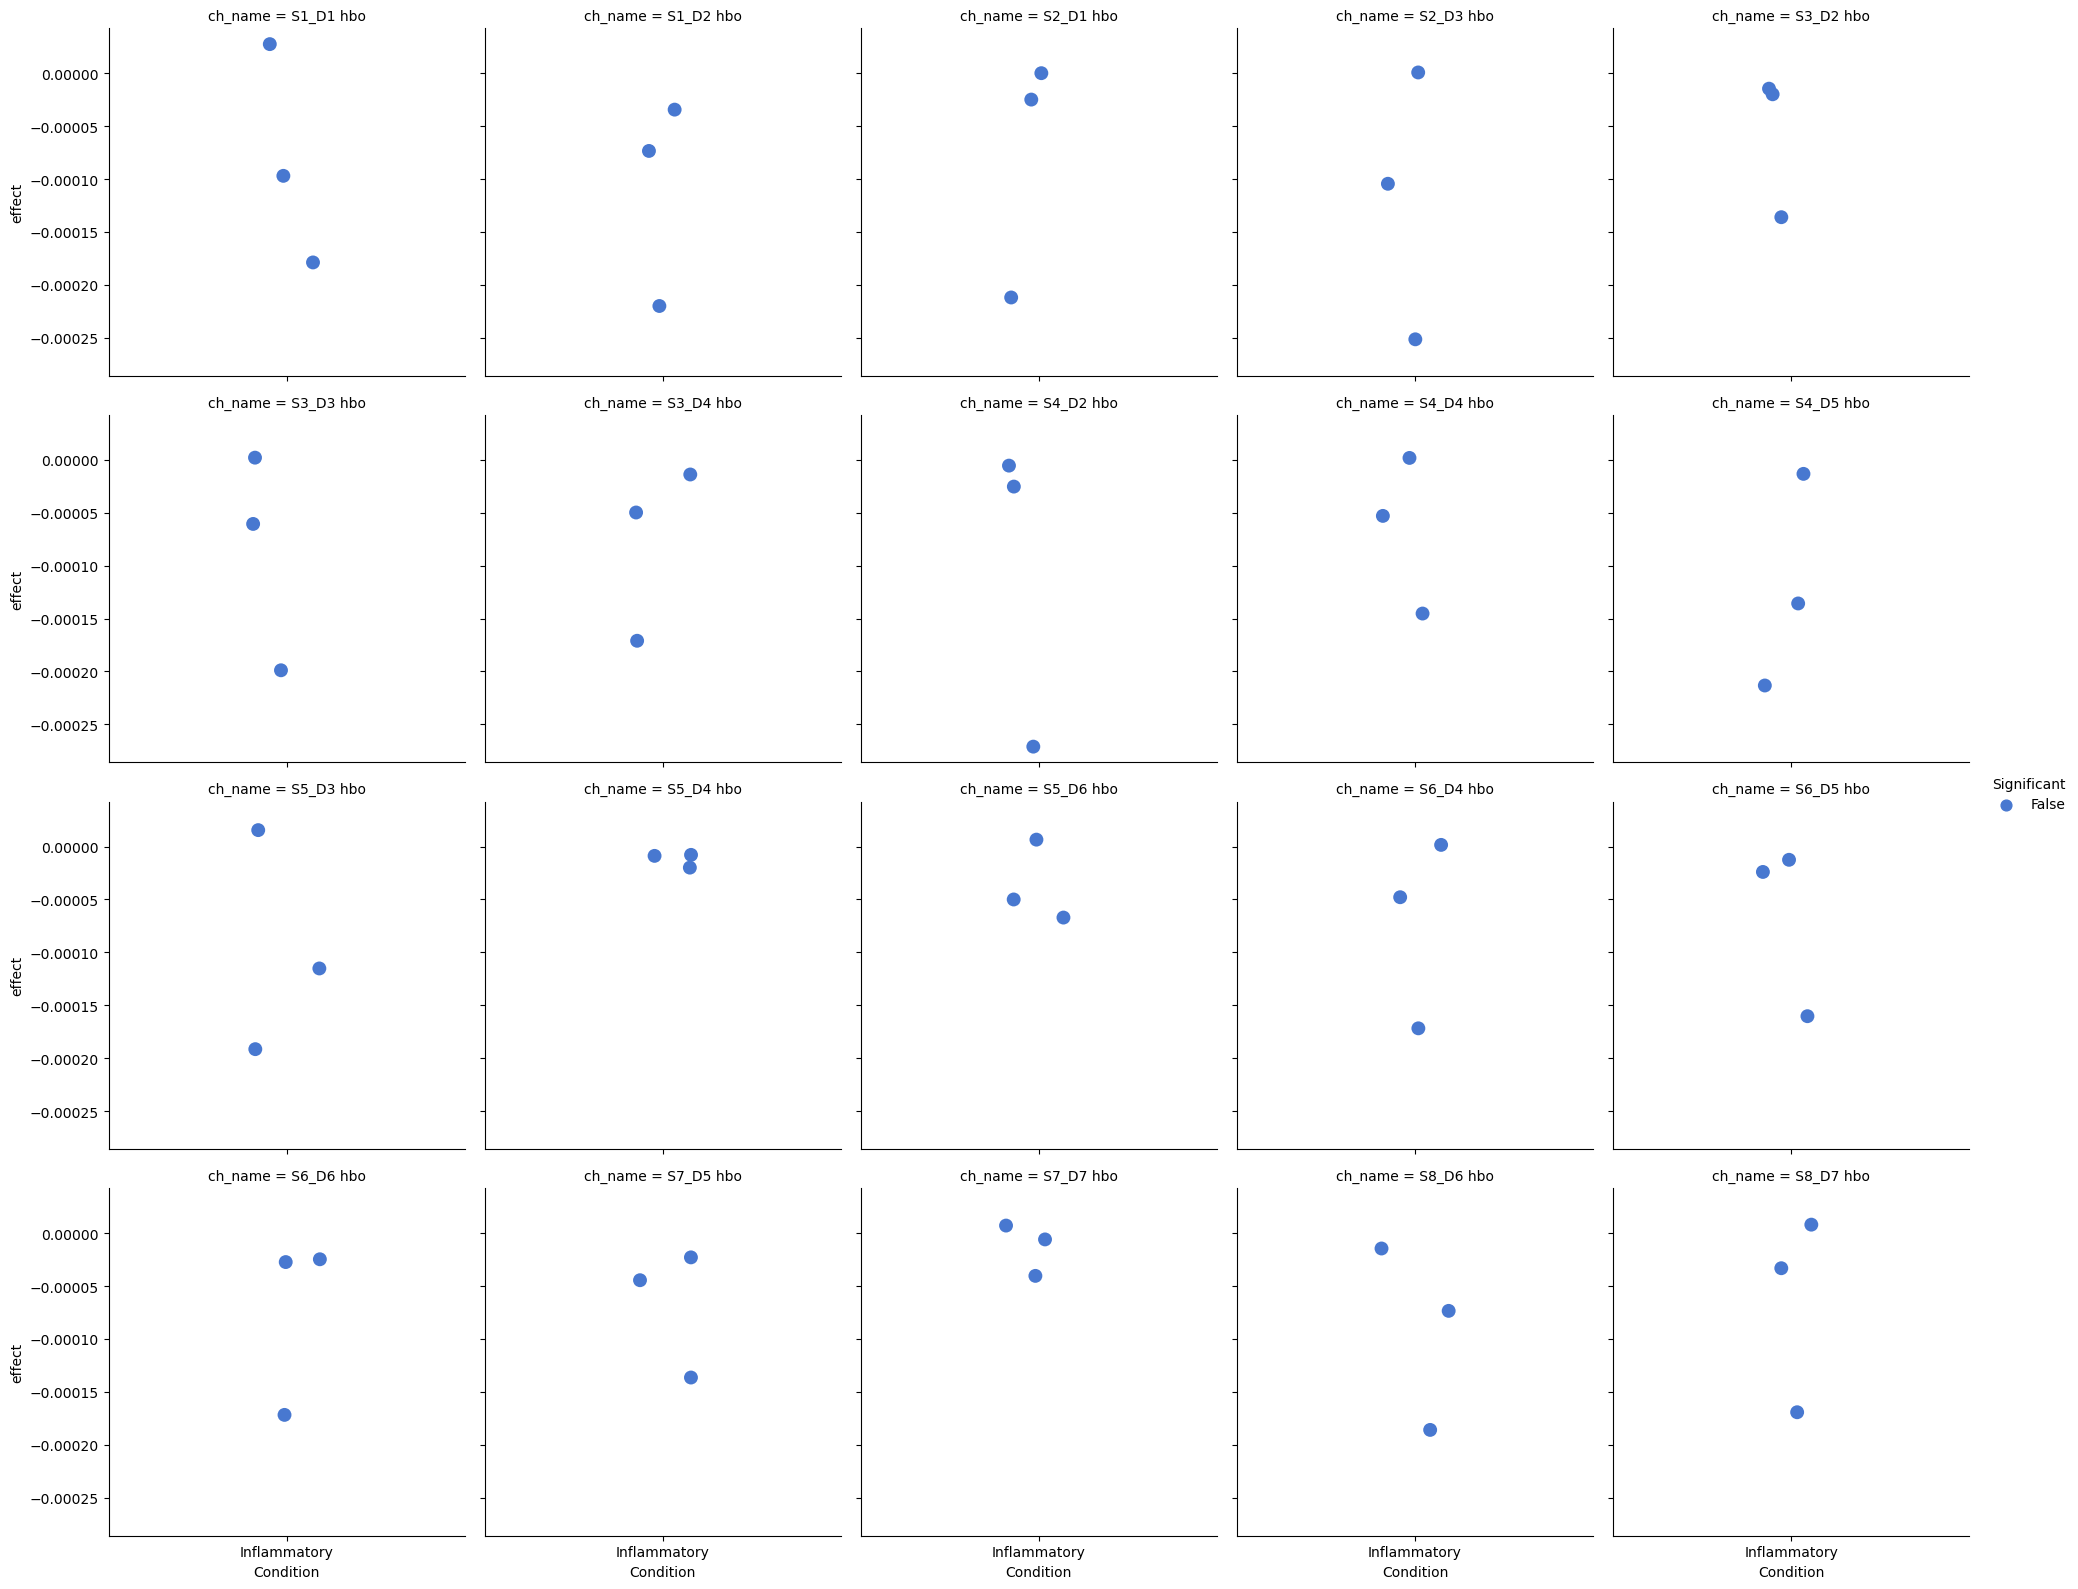

In [6]:
# Plot the Inflam Sensor Results

grp_results = df_con_inflam.query("Condition in ['Neutral', 'Inflammatory']")
grp_results = grp_results.query("Chroma in ['hbo']")

sns.catplot(x="Condition", y="effect", hue='Significant', col="ch_name", data=grp_results, col_wrap=5, ci=None, palette="muted", height=4, s=10)